# Project 2: Topic Classification

In this project, you'll work with text data from newsgroup postings on a variety of topics. You'll train classifiers to distinguish between the topics based on the text of the posts. Whereas with digit classification, the input is relatively dense: a 28x28 matrix of pixels, many of which are non-zero, here we'll represent each document with a "bag-of-words" model. As you'll see, this makes the feature representation quite sparse -- only a few words of the total vocabulary are active in any given document. The bag-of-words assumption here is that the label depends only on the words; their order is not important.

The SK-learn documentation on feature extraction will prove useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
# from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

Load the data, stripping out metadata so that we learn classifiers that only use textual features. By default, newsgroups data is split into train and test sets. We further split the test so we have a dev set. Note that we specify 4 categories to use for this project. If you remove the categories argument from the fetch function, you'll get all 20 categories.

In [2]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test',
                                     remove=('headers', 'footers', 'quotes'),
                                     categories=categories)

num_test = len(newsgroups_test.target)
test_data, test_labels = newsgroups_test.data[int(num_test/2):], newsgroups_test.target[int(num_test/2):]
dev_data, dev_labels = newsgroups_test.data[:int(num_test/2)], newsgroups_test.target[:int(num_test/2)]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print('training label shape:', train_labels.shape)
print('test label shape:', test_labels.shape)
print('dev label shape:', dev_labels.shape)
print('labels names:', newsgroups_train.target_names)

training label shape: (2034,)
test label shape: (677,)
dev label shape: (676,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


In [3]:
unique, counts = np.unique(train_labels, return_counts=True)

for key, count in zip(unique, counts):
    print("{:<20} :{}".format(newsgroups_train.target_names[key], count))


alt.atheism          :480
comp.graphics        :584
sci.space            :593
talk.religion.misc   :377


(1) For each of the first 5 training examples, print the text of the message along with the label.

In [4]:
def P1(num_examples=5):
### STUDENT START ###
    for x, y in zip(train_data[:5], train_labels[:5]):
        print("Text:\n{}".format(x))
        print("Label: {}".format(newsgroups_train.target_names[y]))
        print("\n\n\n")

### STUDENT END ###
P1()

Text:
Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych
Label: comp.graphics




Text:


Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh have been demonstrating such evil corruption
for centuries.
Label: talk.religion.mis

(2) Use CountVectorizer to turn the raw training text into feature vectors. You should use the fit_transform function, which makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").

The vectorizer has a lot of options. To get familiar with some of them, write code to answer these questions:

a. The output of the transform (also of fit_transform) is a sparse matrix: http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. What is the size of the vocabulary? What is the average number of non-zero features per example? What fraction of the entries in the matrix are non-zero? Hint: use "nnz" and "shape" attributes.

b. What are the 0th and last feature strings (in alphabetical order)? Hint: use the vectorizer's get_feature_names function.

c. Specify your own vocabulary with 4 words: ["atheism", "graphics", "space", "religion"]. Confirm the training vectors are appropriately shaped. Now what's the average number of non-zero features per example?

d. Instead of extracting unigram word features, use "analyzer" and "ngram_range" to extract bigram and trigram character features. What size vocabulary does this yield?

e. Use the "min_df" argument to prune words that appear in fewer than 10 documents. What size vocabulary does this yield?

f. Using the standard CountVectorizer, what fraction of the words in the dev data are missing from the vocabulary? Hint: build a vocabulary for both train and dev and look at the size of the difference.

In [137]:
def P2():
### STUDENT START ###
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(train_data)
    vocabulary_size = X.shape[1]
    feature_names = vectorizer.get_feature_names()
    non_zero_fraction = X.nnz/(X.shape[0]*X.shape[1])
    avg_non_zero = non_zero_fraction * X.shape[1]

#     print(X.shape)
    
    print("a.")
    print("The vocabulary size is {}.".format(vocabulary_size))
    print("The average number of non-zero features per example is {:0.3f}.".format(avg_non_zero))
    print("The fraction of non-zero entries is {:0.4f}.".format(non_zero_fraction))

    print("\n\nb.")
    print("The 0th feature string is '{}' and the last is '{}'".format(feature_names[0], feature_names[-1]))

    mini_vocabulary = ["atheism", "graphics", "space", "religion"]
    vectorizer_2 = CountVectorizer(vocabulary=mini_vocabulary)
    X_2 = vectorizer_2.fit_transform(train_data)
    non_zero_fraction_2 = X_2.nnz/(X_2.shape[0]*X_2.shape[1])
    avg_non_zero_2 = non_zero_fraction_2 * X_2.shape[1]
    
    print("\n\nc.")
    print(X_2.shape)
    print("The average number of non-zero features per example is {:0.3f}.".format(avg_non_zero_2))

    vectorizer_3 = CountVectorizer(analyzer='char', ngram_range=(2,3))
    X_3 = vectorizer_3.fit_transform(train_data)
    vocabulary_size_3 = X_3.shape[1] 
    print("\n\nd.")
    print("The vocabulary size for bigrams and trigrams is {}.".format(vocabulary_size_3))
    
    vectorizer_4 = CountVectorizer(min_df=10)
    X_4 = vectorizer_4.fit_transform(train_data)
    vocabulary_size_4 = X_4.shape[1] 
    print("\n\ne.")
    print("The vocabulary for words appearing in 10 documents or more is {}.".format(vocabulary_size_4))
    
    vectorizer_5 = CountVectorizer()
    X_5 = vectorizer_5.fit_transform(dev_data)
    vocabulary_size_5 = X_5.shape[1]
    vocab_delta = vocabulary_size - vocabulary_size_5
    fraction_missing_dev_pc = vocab_delta / vocabulary_size * 100
    
    print("\n\nf.")
    print("There are {} fewer words when using the dev data vs training data. {:0.1f}% of the training words are not found in the dev data (not accounting for words which are unique to each dataset)".format(vocab_delta, fraction_missing_dev_pc))

### STUDENT END ###
P2()

a.
The vocabulary size is 26879.
The average number of non-zero features per example is 96.706.
The fraction of non-zero entries is 0.0036.


b.
The 0th feature string is '00' and the last is 'zyxel'


c.
(2034, 4)
The average number of non-zero features per example is 0.268.


d.
The vocabulary size for bigrams and trigrams is 35478.


e.
The vocabulary for words appearing in 10 documents or more is 3064.


f.
There are 10633 fewer words when using the dev data vs training data. 39.6% of the training words are not found in the dev data (not accounting for words which are unique to each dataset)


(3) Use the default CountVectorizer options and report the f1 score (use metrics.f1_score) for a k nearest neighbors classifier; find the optimal value for k. Also fit a Multinomial Naive Bayes model and find the optimal value for alpha. Finally, fit a logistic regression model and find the optimal value for the regularization strength C using l2 regularization. A few questions:

a. Why doesn't nearest neighbors work well for this problem?

b. Any ideas why logistic regression doesn't work as well as Naive Bayes?

c. Logistic regression estimates a weight vector for each class, which you can access with the coef\_ attribute. Output the sum of the squared weight values for each class for each setting of the C parameter. Briefly explain the relationship between the sum and the value of C.

In [58]:
from sklearn.model_selection import ShuffleSplit

def P3():
### STUDENT START ###

    corpus = train_data 
    y = train_labels
    corpus_test = dev_data
    y_test = dev_labels
    
    # Vectorize the corpora (that's apperently the plural)
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(corpus)
    vectorizer_test = CountVectorizer(vocabulary=vectorizer.get_feature_names())
    X_test = vectorizer_test.fit_transform(corpus_test)
    
    """KNN"""
    # Determine the (near) optimal value for k
    param_grid = {
        'n_neighbors': [1, 2, 4, 8, 10, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200]
    }
    knn = KNeighborsClassifier()
    cv = ShuffleSplit(n_splits=5, test_size=0.5, random_state=0)
    knn_gs = GridSearchCV(knn, param_grid, cv=cv, scoring='accuracy', n_jobs=-1) 
    knn_gs.fit(X, y)
    
    knn_best_n_neighbors = knn_gs.best_params_['n_neighbors']

    # Predict using the value found above
    knn = knn_gs
    knn_y_pred = knn.predict(X_test)

    knn_f1_micro = metrics.f1_score(y_test, knn_y_pred, average="micro")
    knn_f1_macro = metrics.f1_score(y_test, knn_y_pred, average="macro")
    knn_f1_weighted = metrics.f1_score(y_test, knn_y_pred, average="weighted")
    
    print("N Nearest Neighbors: n_neighbors: {} F1 micro: {:0.3f}, F1 macro: {:0.3f}, F1 weighted: {:0.3f}."
          .format(knn_best_n_neighbors, knn_f1_micro, knn_f1_macro, knn_f1_weighted))
    
    """Multinomial Naive Bayes"""
    # Determine the (near) optimal value for alpha
    param_grid = {
        'alpha': [1.0e-10, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 1, 4, 10, 20]
    }
    mnb = MultinomialNB()
    mnb_gs = GridSearchCV(mnb, param_grid, cv=3, scoring='accuracy', n_jobs=-1) 
    mnb_gs.fit(X, y)
    best_alpha = mnb_gs.best_params_['alpha']

    # Predict using the value found above
    mnb_y_pred = mnb_gs.predict(X_test)
    mnb_y_prob = mnb_gs.predict_proba(X_test)

    mnb_f1_micro = metrics.f1_score(y_test, mnb_y_pred, average="micro")
    mnb_f1_macro = metrics.f1_score(y_test, mnb_y_pred, average="macro")
    mnb_f1_weighted = metrics.f1_score(y_test, mnb_y_pred, average="weighted")
    
    print("Logistic Regression: alpha: {} F1 micro: {:0.3f}, F1 macro: {:0.3f}, F1 weighted: {:0.3f}."
          .format(best_alpha, mnb_f1_micro, mnb_f1_macro, mnb_f1_weighted))
    
    
    """Multinomial Naive Bayes"""
    # Determine the (near) optimal value for alpha
    param_grid = {
#         'C': [1.0e-10, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 1, 2, 4, 8, 10, 20]
        'C': [1.0e-10, 1.0e-5, 0.01, 0.02, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 1],
#         'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
#         'multi_class': ['ovr', 'multinomial', 'auto']
    }
    lr = LogisticRegression(penalty='l2', solver='liblinear', multi_class='ovr')
#     lr = LogisticRegression(penalty='l2')
    lr_gs = GridSearchCV(lr, param_grid, cv=3, scoring='accuracy', n_jobs=-1) 
    lr_gs.fit(X, y)
    best_c = lr_gs.best_params_['C']

    # Predict using the value found above
    lr_y_pred = lr_gs.predict(X_test)
    lr_y_prob = lr_gs.predict_proba(X_test)

    lr_f1_micro = metrics.f1_score(y_test, lr_y_pred, average="micro")
    lr_f1_macro = metrics.f1_score(y_test, lr_y_pred, average="macro")
    lr_f1_weighted = metrics.f1_score(y_test, lr_y_pred, average="weighted")
    
    print("Logistic Regression: C: {} F1 micro: {:0.3f}, F1 macro: {:0.3f}, F1 weighted: {:0.3f}."
          .format(best_c, lr_f1_micro, lr_f1_macro, lr_f1_weighted))
    
    cs = [1.0e-10, 0.00001, 0.01, 0.02, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 1]
    for c in cs:
        lr = LogisticRegression(C=c, penalty='l2', solver='newton-cg', multi_class='ovr')
        lr.fit(X, y)
        lr_y_pred = lr.predict(X_test)
        lr_y_prob = lr.predict_proba(X_test)

        lr_f1 = metrics.f1_score(y_test, lr_y_pred, average="macro")
        print("\nUsing C={} resulted in F1: {:0.4f}".format(c, lr_f1))

    #     print("\nUsing C={}".format(c))
        for n in range(4):
            print("\t{:<20}: {:0.3f}".format(newsgroups_train.target_names[n], np.sum(np.power(lr.coef_,2), 1)[n]))

    
### STUDENT END ###
P3()

N Nearest Neighbors: n_neighbors: 120 F1 micro: 0.467, F1 macro: 0.441, F1 weighted: 0.457.
Logistic Regression: alpha: 0.02 F1 micro: 0.787, F1 macro: 0.765, F1 weighted: 0.783.
Logistic Regression: C: 0.2 F1 micro: 0.713, F1 macro: 0.688, F1 weighted: 0.706.


/home/khanna/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



Using C=1e-10 resulted in F1: 0.1137
	alt.atheism         : 0.000
	comp.graphics       : 0.000
	sci.space           : 0.000
	talk.religion.misc  : 0.000


/home/khanna/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



Using C=1e-05 resulted in F1: 0.2578
	alt.atheism         : 0.000
	comp.graphics       : 0.000
	sci.space           : 0.000
	talk.religion.misc  : 0.000

Using C=0.01 resulted in F1: 0.6142
	alt.atheism         : 2.447
	comp.graphics       : 2.976
	sci.space           : 2.822
	talk.religion.misc  : 2.033

Using C=0.02 resulted in F1: 0.6391
	alt.atheism         : 5.402
	comp.graphics       : 5.927
	sci.space           : 5.918
	talk.religion.misc  : 4.449

Using C=0.05 resulted in F1: 0.6607
	alt.atheism         : 14.059
	comp.graphics       : 13.747
	sci.space           : 14.628
	talk.religion.misc  : 11.678

Using C=0.1 resulted in F1: 0.6845
	alt.atheism         : 27.166
	comp.graphics       : 24.760
	sci.space           : 27.530
	talk.religion.misc  : 22.900

Using C=0.15 resulted in F1: 0.6893
	alt.atheism         : 38.981
	comp.graphics       : 34.296
	sci.space           : 39.009
	talk.religion.misc  : 33.148

Using C=0.2 resulted in F1: 0.6878
	alt.atheism         : 49.839
	com

In [7]:
# corpus = train_data 
# y = train_labels
# corpus_test = test_data
# y_test = test_labels

# # Vectorize the corpora (that's apperently the plural)
# vectorizer = CountVectorizer()
# X = vectorizer.fit_transform(corpus)
# vectorizer_test = CountVectorizer(vocabulary=vectorizer.get_feature_names())
# X_test = vectorizer_test.fit_transform(corpus_test)

# cs = [1.0e-10, 0.00001, 0.01, 0.02, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 1]
# for c in cs:
#     lr = LogisticRegression(C=c, penalty='l2', solver='newton-cg', multi_class='ovr')
#     lr.fit(X, y)
#     lr_y_pred = lr.predict(X_test)
#     lr_y_prob = lr.predict_proba(X_test)

#     lr_f1 = metrics.f1_score(y_test, lr_y_pred, average="macro")
#     print("\nUsing C={} resulted in F1: {}".format(c, lr_f1))

# #     print("\nUsing C={}".format(c))
#     for n in range(4):
#         print("\t{:<20}: {:0.3f}".format(newsgroups_train.target_names[n], np.sum(np.power(lr.coef_,2), 1)[n]))

#     # # Explore the results from Logistic Regression
#     lr_fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10.0, 5.0))
#     ax1.hist(lr_y_pred.reshape(-1,1), bins=[0,1,2,3,4])
#     ax1.set_title("Predictions using C={}".format(c))
#     ax1.set_ylabel("Frequency")
#     ax1.set_xlabel("Newsgroup")

#     ax2.hist(lr_y_prob.reshape(-1,1), bins=[0.0,0.2,0.4,0.6,0.8,1])
#     ax2.set_title("Confidence using C={}".format(c))
#     ax2.set_xlabel("Probability")



ANSWER:

a) Why doesn't nearest neighbors work well for this problem?  

There are several reasons KNN doesn't work well for this problem:
* There are a lot more words that are going to be common under any topic.  Additionaly, there are two topics with similar subjects, atheism and religion, so those are likely going to viewed as similar even without other problems inherent with knn in this type of problem.
* The fequency of the word changes the distance which isn't desired, especially when the length of the text isn't being considered where a frequency of 0 is closer to 5 than 12.  So not using a word unique to the topic can often score higher than using it a lot. 
* The order in which words are used is important, and knn doesn't pay any attention to the order.
* It should be noted that adding stop words and other treatments in the vectorization process could improve results.


b) Any ideas why logistic regression doesn't work as well as Naive Bayes?  

Naive Bayes uses conditional probabilities which in this case will likely help some since language only has meaning with context of the words around it.  Order and proximity are also critical to understanding speach, and none of these models take those in to consideration. 

c) Logistic regression estimates a weight vector for each class, which you can access with the coef_ attribute. Output the sum of the squared weight values for each class for each setting of the C parameter. Briefly explain the relationship between the sum and the value of C.  

The sum of the squared coeffecients increase as C is increased.  Negative coeffecients become more decrease and positive increase.  C is the "Inverse of regularization strength", thus, the lower it is the closer the distribution is to being uniform, which means the features have less predictive power. Without the regularization the probability distribution is 


(4) Train a logistic regression model. Find the 5 features with the largest weights for each label -- 20 features in total. Create a table with 20 rows and 4 columns that shows the weight for each of these features for each of the labels. Create the table again with bigram features. Any surprising features in this table?

In [59]:
import pandas as pd
from IPython.display import display

def P4():
### STUDENT START ###
    """Get the the n features with highest coeffecients
    
    Returns list dictionary with the vocabulary feature index as the key
    and the value is a dictionary containing the newsgroup index and the 
    coeffecients for each newsgroup
    
    """
    def _get_top_n(coefs, n):
        all_coefs = {}
        
        for coefs_idx, coef in enumerate(coefs):
            lst = list(coef)
            top_n = dict(zip(range(n), lst[:n]))
            cur_min_key = min(top_n, key=top_n.get)
            cur_min_value = top_n.get(cur_min_key)

            for idx, item in enumerate(lst[-(len(lst)-n):]):
                i = idx+n
                if item > cur_min_value:
                    top_n.pop(cur_min_key)
                    top_n[i] = item
                    cur_min_key = min(top_n, key=top_n.get)
                    cur_min_value = top_n.get(cur_min_key)

            sorted_top_n = dict([(k, top_n[k]) for k in sorted(top_n, key=top_n.get, reverse=True)])
            
            for i in sorted_top_n.keys():
                all_coefs[i] = {'newsgroup': coefs_idx, 
                                'coefs':[coefs[0][i], coefs[1][i], coefs[2][i], coefs[3][i]]}

        return all_coefs
    
    """Vecorize, train and fit training and test data
    
    Return output from _get_top_n and the vocabulary created using training data. 
    """
    def get_top_five_features(bigram):
        # Vectorize the corpora depending on bigram argument 
        if bigram:
            vectorizer = CountVectorizer(analyzer='word', ngram_range=(2,2))
        else:
            vectorizer = CountVectorizer()
            
        X = vectorizer.fit_transform(corpus)
        vocabulary = vectorizer.get_feature_names()
        vectorizer_test = CountVectorizer(vocabulary=vocabulary)
        X_test = vectorizer_test.fit_transform(corpus_test)

        lr = LogisticRegression(C=0.5, penalty='l2', solver='liblinear', multi_class='ovr')
        lr.fit(X, y)
        lr_y_pred = lr.predict(X_test)

        top_fives = _get_top_n(lr.coef_, 5)
    
        return top_fives, vocabulary

    """Create a pandas dataframe for presenting table
    """
    def combine_features_df(top_5s, vocabulary):
        data = []
        for idx, attributes in top_5s.items():
            row=[vocabulary[idx]] + attributes['coefs']
            data.append(row)

        header=[''] + newsgroups_train.target_names
        df = pd.DataFrame(data=data, columns=header)
        
        return df

    corpus = train_data 
    y = train_labels
    corpus_test = dev_data
    y_test = dev_labels
    
    top_five, vocabulary = get_top_five_features(False)
    top_five_bigram, vocabulary_bigram = get_top_five_features(True)
    
    display(combine_features_df(top_five, vocabulary))
    display(combine_features_df(top_five_bigram, vocabulary_bigram))

### STUDENT END ###
P4()

,,alt.atheism,comp.graphics,sci.space,talk.religion.misc
0,atheists,0.833519,-0.093358,-0.267662,-0.637673
1,bobby,0.823676,-0.191267,-0.286395,-0.387241
2,religion,0.798438,-0.508542,-0.658781,-0.050576
3,atheism,0.794459,-0.349004,-0.367186,-0.377055
4,deletion,0.723793,-0.249496,-0.272442,-0.270343
5,graphics,-0.640837,1.626459,-1.102988,-0.626372
6,image,-0.469299,1.116783,-0.672368,-0.380838
7,file,-0.275208,1.059567,-0.682657,-0.506261
8,3d,-0.303524,0.941772,-0.571032,-0.317620
9,computer,0.071360,0.844698,-0.569552,-0.396210


,,alt.atheism,comp.graphics,sci.space,talk.religion.misc
0,claim that,0.605549,-0.199061,-0.274384,-0.140365
1,cheers kent,0.555720,-0.697902,-0.663780,0.534817
2,was just,0.482050,-0.131432,-0.128863,-0.227459
3,you are,0.472740,-0.279916,-0.481429,0.028336
4,are you,0.446953,-0.248266,-0.097166,-0.305631
5,looking for,-0.630341,1.108358,-0.499932,-0.571839
6,in advance,-0.459351,0.832573,-0.438490,-0.418463
7,comp graphics,-0.292166,0.801209,-0.370911,-0.285202
8,out there,-0.274803,0.758677,-0.479008,-0.277092
9,is there,-0.340882,0.754979,-0.468250,-0.257080


ANSWER:

(5) Try to improve the logistic regression classifier by passing a custom preprocessor to CountVectorizer. The preprocessing function runs on the raw text, before it is split into words by the tokenizer. Your preprocessor should try to normalize the input in various ways to improve generalization. For example, try lowercasing everything, replacing sequences of numbers with a single token, removing various other non-letter characters, and shortening long words. If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular. With your new preprocessor, how much did you reduce the size of the dictionary?

For reference, I was able to improve dev F1 by 2 points.

In [175]:
def empty_preprocessor(s):
    return s

def better_preprocessor(s):
### STUDENT START ###
    
    common_english_suffixes = ['able', 'ac', 'acity', 'ocity', 'ade ', 'age', 'aholic', 'oholic', 
                'al', 'algia', 'an', 'ian', 'ance', 'ant', 'ar', 'ard', 'arian', 
                'arium', 'orium', 'ary', 'ate', 'ation', 'ative', 'up', 'cracy', 
                'crat', 'cule', 'cy', 'cycle', 'dom', 'dox', 'up', 'ed', 'ee', 'eer', 
                'emia', 'en', 'ence', 'ency', 'ent', 'er', 'ern', 'up', 'ese', 
                'esque', 'ess', 'est', 'etic', 'ette', 'ful', 'fy', 'gam', 'gamy',
                'gon', 'gonic', 'hood', 'up', 'ian', 'iasis', 'iatric', 'ible', 
                'ic', 'ical', 'ile', 'ily', 'ine', 'ing', 'ion', 'ious', 'ish', 
                'ism', 'ist', 'ite', 'itis', 'ity', 'ive', 'ization', 'ize', 'less', 
                'let', 'up', 'ling', 'loger', 'logist', 'log', 'ly', 'ment', 'ness', 
                'oid', 'up', 'oma', 'onym', 'opia', 'opsy', 'or', 'ory', 'osis', 
                'ostomy', 'otomy', 'ous', 'up', 'pathy', 'phile', 'phobia', 'phone', 
                'phyte', 'plegia', 'plegic', 'pnea', 'scopy', 'scope', 'scribe', 'script', 
                'sect', 'ship', 'sion', 'some', 'sophy', 'sophic', 'up', 'tion', 'tome', 
                'tomy', 'trophy', 'tude', 'ty', 'ular', 'uous', 'ure', 'ward', 'ware', 
                'wise', 'up']

    cleaned_string = s
    
    # Tokenize numbers
    cleaned_string = re.sub('^([\s\d]+)$', "NUMBER", cleaned_string).strip()

    # Remove strange sequences and cars
    cleaned_string = re.sub(r'_', '', cleaned_string)
    
    # Remove plural variations
    cleaned_string = re.sub(r'ies\b|es\b|s\b|y\b', '', cleaned_string)
    
    # Remove suffixes
    for suffix in common_english_suffixes:
        cleaned_string = re.sub(suffix + '\\b', '', cleaned_string)
        
    return cleaned_string

### STUDENT END ###

def P5():
### STUDENT START ###
    corpus = train_data 
    y = train_labels
    corpus_test = dev_data
    y_test = dev_labels

    def fit_score(preprocessor):
        # Vectorize the corpora 
        vectorizer = CountVectorizer(preprocessor=preprocessor)
        X = vectorizer.fit_transform(corpus)
        vectorizer_test = CountVectorizer(vocabulary=vectorizer.get_feature_names(), preprocessor=preprocessor)
        X_test = vectorizer_test.fit_transform(corpus_test)

        lr = LogisticRegression(C=150, penalty='l2', solver='liblinear', multi_class='ovr')
#         lr = LogisticRegression()
        lr.fit(X, y)
        lr_y_pred = lr.predict(X_test)

        lr_f1 = metrics.f1_score(y_test, lr_y_pred, average="macro")
        
        return lr_f1, len(vectorizer.get_feature_names()), vectorizer.get_feature_names()
    
    empty_f1, empty_wc, empty_feature_names = fit_score(empty_preprocessor)
    better_f1, better_wc, better_feature_names = fit_score(better_preprocessor)
    
    word_delta = empty_wc - better_wc
    score_delta = better_f1 - empty_f1
    
    print("Empty preprocessor: vocabulary: {} F1 score: {:0.3f}."
          .format(empty_wc, empty_f1))
    print("Better preprocessor: vocabulary: {} F1 score: {:0.3f}."
          .format(better_wc, better_f1))
    print("The preprocessor reduced the wordcount by {} and increased the score by {:0.3f}"
          .format(word_delta, score_delta))
    
#     print(better_feature_names)
    
### STUDENT END ###
P5()

Empty preprocessor: vocabulary: 33291 F1 score: 0.670.
Better preprocessor: vocabulary: 25105 F1 score: 0.703.
The preprocessor reduced the wordcount by 8186 and increased the score by 0.034


(6) The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. That is, logistic regression seeks the set of weights that minimizes errors in the training data AND has a small size. The default regularization, L2, computes this size as the sum of the squared weights (see P3, above). L1 regularization computes this size as the sum of the absolute values of the weights. The result is that whereas L2 regularization makes all the weights relatively small, L1 regularization drives lots of the weights to 0, effectively removing unimportant features.

Train a logistic regression model using a "l1" penalty. Output the number of learned weights that are not equal to zero. How does this compare to the number of non-zero weights you get with "l2"? Now, reduce the size of the vocabulary by keeping only those features that have at least one non-zero weight and retrain a model using "l2".

Make a plot showing accuracy of the re-trained model vs. the vocabulary size you get when pruning unused features by adjusting the C parameter.

Note: The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.01 (the default is .0001).

In [ ]:
def P6():
    # Keep this random seed here to make comparison easier.
    np.random.seed(0)

    ### STUDENT START ###
    global p6_results_X, p6_results_y
    p6_results_X = []
    p6_results_y = []

    corpus = train_data 
    y = train_labels
    corpus_test = test_data
    y_test = test_labels

    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(corpus)
    feature_names = vectorizer.get_feature_names()

    vectorizer_test = CountVectorizer(vocabulary=feature_names)
    X_test = vectorizer_test.fit_transform(corpus_test)

    default_c=5.0

    cs = [0.01, 0.02, 0.05, 0.1, 0.5, 1.0, 2.0, 3.0, 5.0, 10.0, 20.0]
    cs = [n for n in range(1, 42, 5)]
    for default_c in cs:
        """Train l1"""
        lr_l1 = LogisticRegression(C=default_c, penalty='l1', solver='liblinear', multi_class='ovr', n_jobs=-1)
        lr_l1.fit(X, y)
        lr_l1_y_pred = lr_l1.predict(X_test)
        lr_l1_y_prob = lr_l1.predict_proba(X_test)
        lr_l1_nz_count = np.count_nonzero(lr_l1.coef_)

        """Train l2"""
        lr_l2 = LogisticRegression(C=default_c, penalty='l2', solver='newton-cg', multi_class='ovr', n_jobs=-1)
        lr_l2.fit(X, y)
        lr_l2_y_pred = lr_l2.predict(X_test)
        lr_l2_y_prob = lr_l2.predict_proba(X_test)
        lr_l2_nz_count = np.count_nonzero(lr_l2.coef_)

        """Construct Vocabulary"""
        summed = lr_l1.coef_[0] + lr_l1.coef_[1] + lr_l1.coef_[2] + lr_l1.coef_[3] 
        nonzero_index = np.nonzero(summed)
        pruned_vocabulary = np.array(feature_names)[nonzero_index]

        """Train l2 with new vocab"""
        vectorizer_voc = CountVectorizer(vocabulary=pruned_vocabulary)
        X_voc = vectorizer_voc.fit_transform(corpus)
        feature_names_voc = vectorizer_voc.get_feature_names()

        vectorizer_voc_test = CountVectorizer(vocabulary=feature_names_voc)
        X_voc_test = vectorizer_voc_test.fit_transform(corpus_test)

        lr_l2_voc = LogisticRegression(C=default_c, penalty='l2', solver='newton-cg', multi_class='ovr', n_jobs=-1)
        lr_l2_voc.fit(X_voc, y)
        lr_l2_y_pred_voc = lr_l2_voc.predict(X_voc_test)
        lr_l2_y_prob_voc = lr_l2_voc.predict_proba(X_voc_test)

        lr_l2_voc_nz_count = np.count_nonzero(lr_l2_voc.coef_)
    
    #     print(len(feature_names))
    #     print(len(pruned_vocabulary))
    #     print(pruned_vocabulary)

    #     print(type(summed))
    #     print(summed)
    #     print(np.count_nonzero(summed))

    #     print(type(lr_l1.coef_))
    #     print(lr_l1.coef_)
    #     print(np.count_nonzero(lr_l1.coef_))

    #     print(type(lr_l2.coef_))
    #     print(lr_l2.coef_)
    #     print(np.count_nonzero(lr_l2.coef_))    

    #     print(type(lr_l2_voc.coef_))
    #     print(lr_l2_voc.coef_)
    #     print(np.count_nonzero(lr_l2_voc.coef_))    

        lr_voc = LogisticRegression(C=1.0, tol=.01, penalty='l2', solver='newton-cg', multi_class='ovr', n_jobs=-1)
        lr_voc.fit(X_voc, y)
        lr_voc_y_pred = lr_voc.predict(X_voc_test)
        lr_voc_y_prob = lr_voc.predict_proba(X_voc_test)

        lr_voc_f1 = metrics.f1_score(y_test, lr_voc_y_pred, average="weighted")
        print("Using C={} resulted in F1: {} vocab size: {} "
              .format(default_c, lr_voc_f1, len(pruned_vocabulary)))
        p6_results_X.append(len(pruned_vocabulary))
        p6_results_y.append(lr_voc_f1)
        
#         for n in range(4):
#             print("\t{:<20}: {:0.3f}".format(newsgroups_train.target_names[n], np.sum(np.power(lr.coef_,2), 1)[n]))

#         # # Explore the results from Logistic Regression
#         lr_fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10.0, 5.0))
#         ax1.hist(lr_y_pred.reshape(-1,1), bins=[0,1,2,3,4])
#         ax1.set_title("Predictions using C={}".format(c))
#         ax1.set_ylabel("Frequency")
#         ax1.set_xlabel("Newsgroup")

#         ax2.hist(lr_y_prob.reshape(-1,1), bins=[0.0,0.2,0.4,0.6,0.8,1])
#         ax2.set_title("Confidence using C={}".format(c))
#         ax2.set_xlabel("Probability")

    ### STUDENT END ###
P6()

Using C=1 resulted in F1: 0.7329431147295452 vocab size: 983 


[[0.7329431147295452, 983], [0.7395012649980067, 1875], [0.7382315575522204, 1859], [0.7316330261366921, 2009], [0.737571300655297, 2314], [0.7343555921572548, 2434], [0.7452612570221073, 2593], [0.7330132350898945, 2238], [0.739522736161798, 2819], [0.7434898116225407, 2983]]


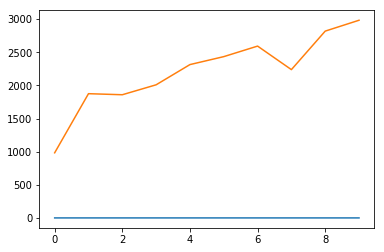

In [214]:
fig = plt.figure()
ax = plt.axes()

ax.plot(p6_results_X, p6_results_y);

(7) Use the TfidfVectorizer -- how is this different from the CountVectorizer? Train a logistic regression model with C=100.

Make predictions on the dev data and show the top 3 documents where the ratio R is largest, where R is:

maximum predicted probability / predicted probability of the correct label

What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

In [210]:
def P7():
### STUDENT START ###
    corpus = train_data 
    y = train_labels
    corpus_test = dev_data
    y_test = dev_labels

    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(corpus)
    feature_names = vectorizer.get_feature_names()

    vectorizer_test = CountVectorizer(vocabulary=feature_names)
    X_test = vectorizer_test.fit_transform(corpus_test)

    lr = LogisticRegression(C=100, penalty='l2', solver='liblinear', multi_class='ovr', n_jobs=-1)
    lr.fit(X, y)
    lr_y_pred = lr.predict(X_test)
    lr_y_prob = lr.predict_proba(X_test)

    print((lr_y_prob.shape))
    print(np.amax(lr_y_prob,1))
    
    lr_f1 = metrics.f1_score(y_test, lr_y_pred, average="weighted")
    print("Using C={} resulted in F1: {}".format(100, lr_f1))
    
    max_prob = np.max(lr_y_prob)
    R = lr_y_prob / max_prob
    
    print(R)
    print(R.shape)

#     """Train l1"""
#     lr_l1 = LogisticRegression(C=default_c, penalty='l1', multi_class='ovr')
#     lr_l1.fit(X, y)
#     lr_l1_y_pred = lr_l1.predict(X_test)
#     lr_l1_y_prob = lr_l1.predict_proba(X_test)
    
#     lr_l1_nz_count = np.count_nonzero(lr_l1.coef_)

#     cs = [1.0e-10, 0.00001, 0.01, 0.02, 0.05, 0.1, 0.5, 1.0, 2.0, 3.0, 5.0, 10, 20, 50, 100, 200]
#     for c in cs:
#         lr = LogisticRegression(C=c,  tol=.01, penalty='l2', solver='liblinear', multi_class='ovr')
#         lr.fit(X, y)
#         lr_y_pred = lr.predict(X_test)
#         lr_y_prob = lr.predict_proba(X_test)

#         lr_f1 = metrics.f1_score(y_test, lr_y_pred, average="macro")
#         print("Using C={} resulted in F1: {}".format(c, lr_f1))
    
## STUDENT END ###
P7()

(676, 4)
(676,)
Using C=100 resulted in F1: 0.7115493841351221
[[2.08923239e-003 1.02278042e-003 9.96693638e-001 1.94349292e-004]
 [3.25752112e-009 9.99999914e-001 8.20204213e-008 3.00920416e-010]
 [6.83071964e-030 1.00000000e+000 1.62405802e-013 8.42364768e-029]
 ...
 [1.90034624e-027 1.08926878e-038 1.00000000e+000 1.27792820e-049]
 [9.29861294e-042 1.10021636e-110 1.00000000e+000 2.21338116e-090]
 [6.66927549e-003 4.59259957e-013 5.24708010e-012 9.93330725e-001]]
(676, 4)


ANSWER:

(8) EXTRA CREDIT

Try implementing one of your ideas based on your error analysis. Use logistic regression as your underlying model.

In [193]:
from IPython.display import Markdown
words = Markdown("## Hello foo  \n This is another *foo*")

display(words)

foo = [n for n in range(1, 32, 3)]
print(type(foo))
print(foo)

print(range(1, 100, 4))

## Hello foo  
 This is another *foo*

<class 'list'>
[1, 4, 7, 10, 13, 16, 19, 22, 25, 28, 31]
range(1, 100, 4)
